<p style="padding: 10px;
          font-size:50px;
          font-weight: bolder;
          color: rgba(124, 203, 234, 0.75)">
    Task 2
</p>

<a name="000" style="color: black">
    <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
        Table of Сontents
    </p>
</a>

<div style="padding: 20px;
            margin-top: 20px;
            color: black;
            background: rgba(124,203,234,0.25)">
    <ol>
        <li><a href="#001">Dataset</a></li>
        <li><a href="#002">Model Training</a></li>
        <li><a href="#003">SHAP Explainer</a></li>
        <li><a href="#004">LIME Explainer</a></li>
        <li><a href="#005">Conclusion</a></li>
    </ol>
</div>

In [1]:
import os
import warnings

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
warnings.filterwarnings(action="ignore")

In [28]:
import torch
import torch.nn as nn
from catalyst import dl
from torch.utils.data import Dataset
import torchvision

import shap
import numpy as np
import pandas as pd
import PIL.Image as Image
from lime import lime_image
import matplotlib.pyplot as plt
from skimage import io, transform
from skimage.segmentation import mark_boundaries
import seaborn as sns
import time

In [3]:
sns.set_style("whitegrid")
%matplotlib inline

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="001" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Dataset
        </p>
    </a>
</blockquote>

In the course of the work, the task of classifying 15 Simpson characters was solved using a convolutional neural network MobileNet V2. The task is devoted to the use of lightweight models for classifying objects on custom datasets and interpretability of results.

Dataset: The Simpsons Characters Data

Link: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset

In [4]:
class SimpsonsDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with annotations.
            transform (callable, optional): Optional transform object.
        """
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        label = self.dataframe.loc[index, "targets"].astype("float")
        
        image_name = self.dataframe.loc[index, "path"]
        image = io.imread(image_name)
        
        sample = {"features": image, "targets": label}
        
        # Image augmentation is recommended.
        # See more: https://pytorch.org/vision/master/transforms.html.
        if self.transform:
            sample = self.transform(sample)
        
        return sample

Class `Rescale` resizes original image to the desired size.

Class `ToTensor` converts input to tensor format.

Class `Normalize` performs data normalization using ImageNet normalization options.

In [5]:
class Rescale(object):
    """Rescale image in a sample to a given size.
    """
    
    def __init__(self, output_size):
        """
        Args:
            output_size (tuple | int): Desired output size.
        """
        
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, label = sample["features"], sample["targets"]
        
        height, width = image.shape[:2]
        if isinstance(self.output_size, int):
            if height > width:
                out_height, out_width = self.output_size * height / width, self.output_size
            else:
                out_height, out_width = self.output_size, self.output_size * width / height
        else:
            out_height, out_width = self.output_size
        
        out_height, out_width = int(out_height), int(out_width)
        
        image = transform.resize(image, (out_height, out_width))
        
        return {"features": image, "targets": label}


class ToTensor(object):
    """Convert ndarrays in sample to tensors.
    """
    
    def __call__(self, sample):
        image, label = sample["features"], sample["targets"]
        
        # Swap color axis.
        image = image.transpose((2, 0, 1))
        return {"features": torch.from_numpy(image).float(), "targets": torch.tensor(label).type(torch.LongTensor)}


class Normalize(object):
    """Normilize image in a sample.
    """
    
    def __call__(self, sample):
        image, label = sample["features"], sample["targets"]
        
        normalization = torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        return {"features": normalization(image).float(), "targets": label.type(torch.LongTensor)}

In order to increase the efficiency of training, augmentation close to ImageNet was used. Image resizing to 128×128 and normalization of pixel intensity values were used.

In [6]:
transforms = torchvision.transforms.Compose([Rescale(output_size=(128, 128)), ToTensor(), Normalize()])

In [7]:
train_dataset = SimpsonsDataset(csv_file="simpsons_train.csv", transform=transforms)
test_dataset = SimpsonsDataset(csv_file="simpsons_test.csv", transform=transforms)

In [8]:
loaders = {
    "train": torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True),
    "valid": torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False),
}

Visualization of the first batch of the training set is shown below.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mr. Burns | Mr. Burns | Apu | Homer | Grampa | Bob | Krusty | Mr. Burns | Milhouse | Flanders | Mr. Burns | Moe | Bart | Marge | Flanders | Marge | Marge | Milhouse | Homer | Krusty | Krusty | Homer | Chief | Bart | Flanders | Milhouse | Milhouse | Bart | Comic Book Guy | Milhouse | Chief | Homer


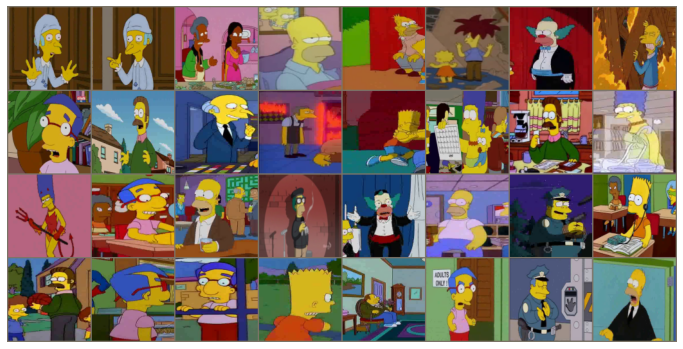

In [9]:
classes = [
    "Grampa", "Apu", "Bart",
    "Mr. Burns","Chief", "Comic Book Guy",
    "Homer", "Krusty", "Lisa",
    "Marge", "Milhouse", "Moe",
    "Flanders", "Skinner", "Bob"
]

def plot_dataloader(dataloader):
    images, labels = dataloader["features"], dataloader["targets"]
    images = torchvision.utils.make_grid(images).numpy()
    images = np.transpose(images, axes=(1, 2, 0))
    images = np.array([0.229, 0.224, 0.225]) * images + np.array([0.485, 0.456, 0.406])
    
    print(" | ".join(f"{classes[int(labels[i])]}" for i in range(32)))
    plt.figure(figsize=(12, 12))
    plt.imshow(images)
    plt.axis("off")
    plt.show()

plot_dataloader(next(iter(loaders["train"])))

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="002" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Model Training
        </p>
    </a>
</blockquote>

`MobileNet V2` was trained to classify Simpsons.

In [10]:
def mobilenet_v2(pretrained=True):
    model = torchvision.models.mobilenet_v2(pretrained=pretrained)
    
    model.classifier = nn.Sequential(
        nn.Linear(1280, 500),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.2),
        nn.Linear(500, 15)
    )
    
    return model

In [11]:
model = mobilenet_v2(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [12]:
runner = dl.SupervisedRunner(
    input_key="features", output_key="logits", target_key="targets", loss_key="loss"
)

In [13]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=10,
    callbacks=[dl.AccuracyCallback(input_key="logits", target_key="targets", topk=(1, 3, 5))],
    logdir="./logs",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
)

1/10 * Epoch (train):   0%|          | 0/442 [00:00<?, ?it/s]

train (1/10) accuracy01: 0.8094463691653779 | accuracy01/std: 0.15772269228987923 | accuracy03: 0.9232128968394261 | accuracy03/std: 0.10923106036605625 | accuracy05: 0.9564448843951067 | accuracy05/std: 0.07895963354676379 | loss: 0.6386891240544442 | loss/mean: 0.6386891240544442 | loss/std: 0.46880975292929655 | lr: 0.1 | momentum: 0.0


1/10 * Epoch (valid):   0%|          | 0/111 [00:00<?, ?it/s]

valid (1/10) accuracy01: 0.8563348416289595 | accuracy01/std: 0.05950788175367547 | accuracy03: 0.9547511312217196 | accuracy03/std: 0.032884354372720165 | accuracy05: 0.9773755656108599 | accuracy05/std: 0.026937222050305996 | loss: 0.5161662402465872 | loss/mean: 0.5161662402465872 | loss/std: 0.24234470892739698 | lr: 0.1 | momentum: 0.0
* Epoch (1/10) 


2/10 * Epoch (train):   0%|          | 0/442 [00:00<?, ?it/s]

train (2/10) accuracy01: 0.9256876192537596 | accuracy01/std: 0.048208937711333597 | accuracy03: 0.977303259499818 | accuracy03/std: 0.026587091887834098 | accuracy05: 0.9897475783072898 | accuracy05/std: 0.018292530263835358 | loss: 0.25942736549166884 | loss/mean: 0.25942736549166884 | loss/std: 0.16226933725462012 | lr: 0.1 | momentum: 0.0


2/10 * Epoch (valid):   0%|          | 0/111 [00:00<?, ?it/s]

valid (2/10) accuracy01: 0.932126696832579 | accuracy01/std: 0.0383920343275445 | accuracy03: 0.9785067873303169 | accuracy03/std: 0.02410500272105771 | accuracy05: 0.9878393665158371 | accuracy05/std: 0.020223942566937263 | loss: 0.2460364057214686 | loss/mean: 0.2460364057214686 | loss/std: 0.1640954266578865 | lr: 0.1 | momentum: 0.0
* Epoch (2/10) 


3/10 * Epoch (train):   0%|          | 0/442 [00:00<?, ?it/s]

train (3/10) accuracy01: 0.9424450257446044 | accuracy01/std: 0.04371571147751069 | accuracy03: 0.9852930777844826 | accuracy03/std: 0.020818813984316505 | accuracy05: 0.9927172452171343 | accuracy05/std: 0.014792761527084803 | loss: 0.19499403862979992 | loss/mean: 0.19499403862979992 | loss/std: 0.14009052384740675 | lr: 0.1 | momentum: 0.0


3/10 * Epoch (valid):   0%|          | 0/111 [00:00<?, ?it/s]

valid (3/10) accuracy01: 0.9290158371040724 | accuracy01/std: 0.043682910129425184 | accuracy03: 0.9807692307692305 | accuracy03/std: 0.02661904589975395 | accuracy05: 0.9903846153846155 | accuracy05/std: 0.017218759900913226 | loss: 0.2738828379713522 | loss/mean: 0.2738828379713522 | loss/std: 0.2240610815881995 | lr: 0.1 | momentum: 0.0
* Epoch (3/10) 


4/10 * Epoch (train):   0%|          | 0/442 [00:00<?, ?it/s]

train (4/10) accuracy01: 0.9560206461928821 | accuracy01/std: 0.03721243393473932 | accuracy03: 0.9892526338117797 | accuracy03/std: 0.01706095691456943 | accuracy05: 0.9958283249664144 | accuracy05/std: 0.011036706004893057 | loss: 0.14937326650088523 | loss/mean: 0.14937326650088523 | loss/std: 0.1251786361589025 | lr: 0.1 | momentum: 0.0


4/10 * Epoch (valid):   0%|          | 0/111 [00:00<?, ?it/s]

valid (4/10) accuracy01: 0.947398190045249 | accuracy01/std: 0.03794980436844055 | accuracy03: 0.9830316742081447 | accuracy03/std: 0.020038156335651723 | accuracy05: 0.98868778280543 | accuracy05/std: 0.017214113089358905 | loss: 0.21203634187545442 | loss/mean: 0.21203634187545442 | loss/std: 0.16700250910880746 | lr: 0.1 | momentum: 0.0
* Epoch (4/10) 


5/10 * Epoch (train):   0%|          | 0/442 [00:00<?, ?it/s]

train (5/10) accuracy01: 0.968394258517419 | accuracy01/std: 0.032193987556489286 | accuracy03: 0.9931414834193593 | accuracy03/std: 0.014542895872912518 | accuracy05: 0.9974545711659477 | accuracy05/std: 0.008802844394667093 | loss: 0.11012227772695213 | loss/mean: 0.11012227772695213 | loss/std: 0.10295258416102811 | lr: 0.1 | momentum: 0.0


5/10 * Epoch (valid):   0%|          | 0/111 [00:00<?, ?it/s]

valid (5/10) accuracy01: 0.9615384615384615 | accuracy01/std: 0.03169194352011652 | accuracy03: 0.9850113122171947 | accuracy03/std: 0.02135342489157391 | accuracy05: 0.9915158371040723 | accuracy05/std: 0.016245770753069644 | loss: 0.17950632450343598 | loss/mean: 0.17950632450343598 | loss/std: 0.22561613727356766 | lr: 0.1 | momentum: 0.0
* Epoch (5/10) 


6/10 * Epoch (train):   0%|          | 0/442 [00:00<?, ?it/s]

train (6/10) accuracy01: 0.9730608781729478 | accuracy01/std: 0.03141294411280695 | accuracy03: 0.9943434914798837 | accuracy03/std: 0.013585108662491767 | accuracy05: 0.9978788093049563 | accuracy05/std: 0.008137050332698225 | loss: 0.0966394829289793 | loss/mean: 0.0966394829289793 | loss/std: 0.1056543438105182 | lr: 0.1 | momentum: 0.0


6/10 * Epoch (valid):   0%|          | 0/111 [00:00<?, ?it/s]

valid (6/10) accuracy01: 0.9445701357466064 | accuracy01/std: 0.04069584497359067 | accuracy03: 0.9819004524886876 | accuracy03/std: 0.023958527104386108 | accuracy05: 0.9898190045248869 | accuracy05/std: 0.018868143399159286 | loss: 0.2243028003332623 | loss/mean: 0.2243028003332623 | loss/std: 0.19258026085373997 | lr: 0.1 | momentum: 0.0
* Epoch (6/10) 


7/10 * Epoch (train):   0%|          | 0/442 [00:00<?, ?it/s]

train (7/10) accuracy01: 0.9714346319734142 | accuracy01/std: 0.03077866950934725 | accuracy03: 0.994697023262391 | accuracy03/std: 0.013151496816899396 | accuracy05: 0.9978788093049568 | accuracy05/std: 0.008663169607443979 | loss: 0.0964604315353913 | loss/mean: 0.0964604315353913 | loss/std: 0.09576011052018293 | lr: 0.1 | momentum: 0.0


7/10 * Epoch (valid):   0%|          | 0/111 [00:00<?, ?it/s]

valid (7/10) accuracy01: 0.9505090497737555 | accuracy01/std: 0.03627485719631548 | accuracy03: 0.9830316742081447 | accuracy03/std: 0.02047457078413459 | accuracy05: 0.9915158371040725 | accuracy05/std: 0.01624577075306966 | loss: 0.2037285207876117 | loss/mean: 0.2037285207876117 | loss/std: 0.1818350715037266 | lr: 0.1 | momentum: 0.0
* Epoch (7/10) 


8/10 * Epoch (train):   0%|          | 0/442 [00:00<?, ?it/s]

train (8/10) accuracy01: 0.9826769425939281 | accuracy01/std: 0.024117296102733478 | accuracy03: 0.9980202220179596 | accuracy03/std: 0.007897600804406749 | accuracy05: 0.9992222300784841 | accuracy05/std: 0.0048684761355946155 | loss: 0.05764602559987839 | loss/mean: 0.05764602559987839 | loss/std: 0.07095855728104064 | lr: 0.1 | momentum: 0.0


8/10 * Epoch (valid):   0%|          | 0/111 [00:00<?, ?it/s]

valid (8/10) accuracy01: 0.9570135746606334 | accuracy01/std: 0.032148714499416677 | accuracy03: 0.9858597285067876 | accuracy03/std: 0.020028172698772898 | accuracy05: 0.9915158371040725 | accuracy05/std: 0.015692186842463218 | loss: 0.16364325985114395 | loss/mean: 0.16364325985114395 | loss/std: 0.17801619501013335 | lr: 0.1 | momentum: 0.0
* Epoch (8/10) 


9/10 * Epoch (train):   0%|          | 0/442 [00:00<?, ?it/s]

train (9/10) accuracy01: 0.9818284663791275 | accuracy01/std: 0.02385648924032987 | accuracy03: 0.9974545711659483 | accuracy03/std: 0.009291339460336083 | accuracy05: 0.9993636427914865 | accuracy05/std: 0.004413908677368282 | loss: 0.06251302063373586 | loss/mean: 0.06251302063373586 | loss/std: 0.08038102256598728 | lr: 0.1 | momentum: 0.0


9/10 * Epoch (valid):   0%|          | 0/111 [00:00<?, ?it/s]

valid (9/10) accuracy01: 0.9496606334841626 | accuracy01/std: 0.03354193794614055 | accuracy03: 0.9833144796380089 | accuracy03/std: 0.020491170338728538 | accuracy05: 0.9901018099547513 | accuracy05/std: 0.01781813951379431 | loss: 0.20222140755609724 | loss/mean: 0.20222140755609724 | loss/std: 0.19408576620023632 | lr: 0.1 | momentum: 0.0
* Epoch (9/10) 


10/10 * Epoch (train):   0%|          | 0/442 [00:00<?, ?it/s]

train (10/10) accuracy01: 0.9831718870936534 | accuracy01/std: 0.022842456408290177 | accuracy03: 0.9980909283744603 | accuracy03/std: 0.008053372844862313 | accuracy05: 0.999434349147989 | accuracy05/std: 0.004166275980981521 | loss: 0.05495986846697861 | loss/mean: 0.05495986846697861 | loss/std: 0.07100939317828657 | lr: 0.1 | momentum: 0.0


10/10 * Epoch (valid):   0%|          | 0/111 [00:00<?, ?it/s]

valid (10/10) accuracy01: 0.9510746606334842 | accuracy01/std: 0.03739073204529945 | accuracy03: 0.986425339366516 | accuracy03/std: 0.021264258313862895 | accuracy05: 0.9923642533936652 | accuracy05/std: 0.015845656213251624 | loss: 0.21132799348166018 | loss/mean: 0.21132799348166018 | loss/std: 0.21641103549186638 | lr: 0.1 | momentum: 0.0
* Epoch (10/10) 
Top models:
./logs\checkpoints/model.0008.pth	0.1636


Model was validated on the first batch of the test set. Final accuracy of the model after 10 training epochs was `98.27%` on the training set and `95.7%` on the test one.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target:
Skinner | Mr. Burns | Chief | Krusty | Grampa | Chief | Homer | Krusty | Moe | Homer | Marge | Moe | Flanders | Bart | Flanders | Krusty | Grampa | Mr. Burns | Apu | Marge | Bart | Marge | Flanders | Skinner | Marge | Homer | Mr. Burns | Comic Book Guy | Homer | Milhouse | Flanders | Grampa


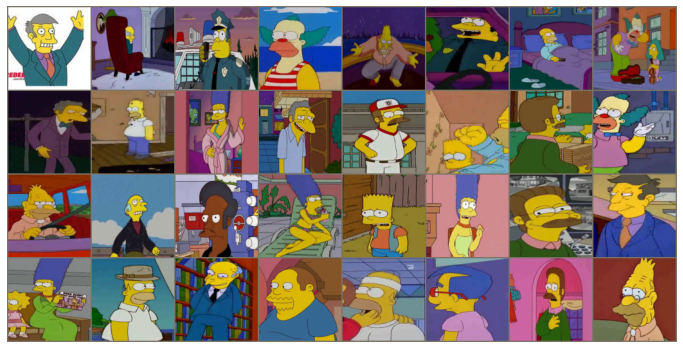

Prediction:
Skinner Mr. Burns Chief Krusty Grampa Chief Homer Krusty Moe Homer Marge Moe Flanders Lisa Flanders Krusty Grampa Moe Apu Marge Bart Marge Flanders Skinner Marge Homer Mr. Burns Comic Book Guy Homer Milhouse Flanders Grampa


In [15]:
valid_loader = next(iter(loaders["valid"]))
print("Target:")
plot_dataloader(valid_loader)

for prediction in runner.predict_loader(loader=loaders["valid"]):
    print("Prediction:")
    logits = prediction["logits"].detach().cpu().numpy().argmax(axis=1)
    print(" ".join(f"{classes[logits[i]]}" for i in range(32)))
    break

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="003" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            SHAP Explainer
        </p>
    </a>
</blockquote>

In [16]:
model = mobilenet_v2(pretrained=False)
device = torch.device("cpu")

checkpoint = torch.load("logs/checkpoints/model.best.pth", map_location=device)
model.load_state_dict(checkpoint, strict=True)

model = model.eval()

In [21]:
classes = [
    "Grampa", "Apu", "Bart",
    "Mr. Burns","Chief", "Comic Book Guy",
    "Homer", "Krusty", "Lisa",
    "Marge", "Milhouse", "Moe",
    "Flanders", "Skinner", "Bob"
]

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.Lambda(lambda x: x*(1/255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transforms = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

def predict(image: np.ndarray) -> torch.Tensor:
    image = nhwc_to_nchw(torch.Tensor(image))
    image = image.to(device)
    output = model(image)
    return output

I use a random custom image from the Internet to predict the Simpson character, which is different from those on which the model was trained.

Classes: [12]: ['Flanders']


  0%|          | 0/998 [00:00<?, ?it/s]

Partition explainer: 2it [00:12, 12.37s/it]                                                                            


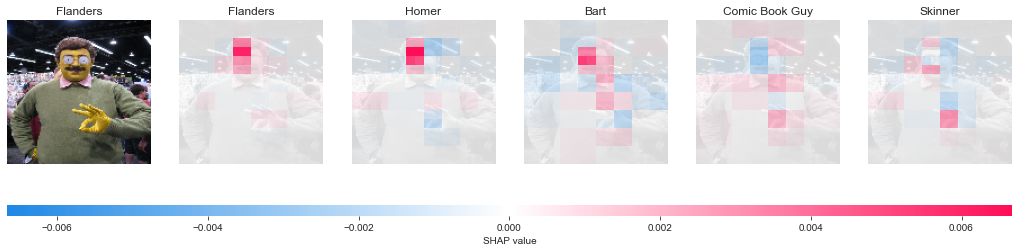

In [22]:
image = io.imread("test.jpg")
X = transforms(torch.Tensor(image).unsqueeze(0)).to(device)
output = predict(X)
labels = torch.argmax(output, axis=1).cpu().numpy()
print(f"Classes: {labels}: {np.array(classes)[labels]}")

topk = 5
batch_size = 32
n_evals = 1000

masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)
explainer = shap.Explainer(predict, masker_blur, output_names=classes)
shap_values = explainer(X, max_evals=n_evals, batch_size=batch_size,
                        outputs=shap.Explanation.argsort.flip[:topk])

shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)]

shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names,
                true_labels=[classes[12]])

SHAP values visualization as the most significant areas on the particular image.

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="004" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            LIME Explainer
        </p>
    </a>
</blockquote>

In [24]:
image = Image.open("test.jpg")

In [25]:
def get_pil_transform():
    transformed = torchvision.transforms.Compose([
        torchvision.transforms.Resize((128, 128))
    ])
    
    return transformed


def get_preprocess_transform():
    normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transformed = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        normalize
    ])
    
    return transformed


def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    
    device = "cpu"
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = torch.nn.Softmax()(logits)
    
    return probs.detach().cpu().numpy()


pill_transformed = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [26]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transformed(image)),
                                         batch_predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Lime uses mask on image and showes the areas that are encouraging the top prediction.

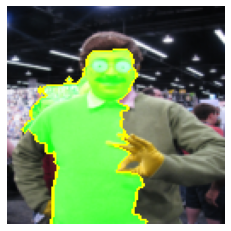

In [31]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=1,
    hide_rest=False
)

img_boundry = mark_boundaries(temp / 255.0, mask)
plt.imshow(img_boundry)
plt.axis("off")
plt.show()

Areas that contributes against the top prediction.

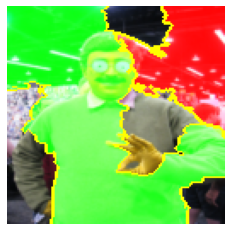

In [37]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False
)

img_boundry = mark_boundaries(temp / 255.0, mask)
plt.imshow(img_boundry)
plt.axis("off")
plt.show()

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="004" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Conclusion
        </p>
    </a>
</blockquote>

In the course of the work, the problem of interpreting the results of image classification was solved. The SHAP explainer uses the blur technique to extract the pixels that contributed the most to model prediction. Thus, we can choose any level of model confidence and study the regions of pixels that are responsible not only for the correct prediction, but also the rest.

This task can be useful for visualizing the latency of the feature space and understanding what distinguishes the images of different classes in our dataset.

LIME explainer allows to impose a feature mask on the original image and visually display the regions that vote for or against the decision of the model.

This task is useful for applying augmentation to original images. Such an overlay will effectively display the role of which features need to be evaded or reduced in the image.